# The Nature Conservancy Fisheries Monitoring

This notebook contains code for the nature conservancy fisheries monitoring competition for Kaggle

## Initial Setup

Import libraries and functions for future use.

In [1]:
# Plots displayed inline in notebook
%matplotlib inline

# Make help libraries available
import sys

#sys.path.append('/home/ubuntu/personal-libraries')
sys.path.append('D:/anlaursen/libraries')

# Set visible devices, so as to just use a single GPU.
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [74]:
import numpy as np
import ujson as json
import pandas as pd
import scipy

from glob import glob
from shutil import copyfile
from collections import Counter
from PIL import Image
from matplotlib import pyplot as plt

from kerastools.utils import (get_batches, get_data, save_array, load_array,
                              get_classes, split_at, MixIterator, to_plot, 
                              plot, do_clip)
from kerastools.vgg16 import Vgg16

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.utils import to_categorical, get_file
from keras import backend as K

We create the desired folder structure. First setup relevant path names that will be utilised repeatedly:

In [8]:
current_dir = os.getcwd()
DATA_HOME_DIR = current_dir

# Allow relative imports to directories above root/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#path = 'sample'
path = ''
batch_size = 32

Set up initial batches

In [9]:
train_batches = get_batches(path + 'train', batch_size = batch_size)

(valid_classes, train_classes, valid_labels, train_labels, 
    valid_filenames, filenames, test_filenames) = get_classes(path)

fish_classes = list(train_batches.class_indices.keys())

Found 3281 images belonging to 8 classes.
Found 3281 images belonging to 8 classes.
Found 496 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


Get paths to the raw files.

In [129]:
raw_filenames = [f.split('\\')[-1] for f in filenames]
raw_test_filenames = [f.split('\\')[-1] for f in test_filenames]
raw_test_stg2_filenames = [f.split('\\')[-1] for f in get_batches(path + 'test_stg2', shuffle = False, batch_size = 1).filenames]
raw_valid_filenames = [f.split('\\')[-1] for f in valid_filenames]

Found 12153 images belonging to 1 classes.


## Setting up the right folder structure

Assumed dataset is from the Kaggle [nature conservancy fisheries monitoring](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/data)

Unzipping the data yields this folder structure:
```
train/
    ALB
        img_2213.jpg
        img_1245.jpg
        img_5654.jpg
        ...
    BET
        img_5434.jpg
        img_1254.jpg
        img_6324.jpg
        ...
    DOL
        img_3421.jpg
        img_5314.jpg
        img_1335.jpg
        ...
    ...
test/
    img_00005.jpg
    img_00007.jpg
    img_00009.jpg
    ...
test_stg2/
    img_00001.jpg
    img_00002.jpg
    img_00003.jpg
    ...
```
Working directory is root of this folder structure.

We create the top directories

In [12]:
%cd $DATA_HOME_DIR

%mkdir valid
%mkdir sample\train
%mkdir sample\valid
%mkdir test\unknown
%mkdir test_stg2\unknown
%mkdir models
%mkdir results
%mkdir sample\results

D:\anlaursen\kaggle\the-nature-conservancy-fisheries-monitoring


A subdirectory or file valid already exists.
A subdirectory or file sample\train already exists.
A subdirectory or file sample\valid already exists.
A subdirectory or file test_stg1\unknown already exists.
A subdirectory or file test_stg2\unknown already exists.
A subdirectory or file models already exists.
A subdirectory or file results already exists.


Next we make the class subfolder

In [5]:
%cd DATA_HOME_DIR\valid
for fish in fish_classes:
    os.mkdir(fish)

[WinError 3] The system cannot find the path specified: 'DATA_HOME_DIR\\valid'
D:\anlaursen\kaggle\the-nature-conservancy-fisheries-monitoring


In [29]:
%cd $DATA_HOME_DIR\sample\train
for fish in fish_classes:
    os.mkdir(fish)

D:\anlaursen\kaggle\the-nature-conservancy-fisheries-monitoring\sample\train


In [30]:
%cd $DATA_HOME_DIR\sample\valid
for fish in fish_classes:
    os.mkdir(fish)

D:\anlaursen\kaggle\the-nature-conservancy-fisheries-monitoring\sample\valid


First we move the test data.

In [45]:
%cd $DATA_HOME_DIR\test

test_stg1_files = [f for f in os.listdir() if os.path.isfile(os.path.join(f))]
for f in test_stg1_files:
    os.rename(DATA_HOME_DIR + '\\test\\' + f, DATA_HOME_DIR + '\\test\\unknown\\' + f)

D:\anlaursen\kaggle\the-nature-conservancy-fisheries-monitoring\test_stg1


In [46]:
%cd $DATA_HOME_DIR\test_stg2

test_stg2_files = [f for f in os.listdir() if os.path.isfile(os.path.join(f))]
for f in test_stg2_files:
    os.rename(DATA_HOME_DIR + '\\test_stg2\\' + f, DATA_HOME_DIR + '\\test_stg2\\unknown\\' + f)

D:\anlaursen\kaggle\the-nature-conservancy-fisheries-monitoring\test_stg2


Next we move the validation files.

In [6]:
% cd $DATA_HOME_DIR\train

valid_size = 500
total_train = len(glob('*/*.jpg'))

# Make the validation set reflect the composition of the training set
for fish in fish_classes:
    g = os.listdir(fish + '\\')
    shuf = np.random.permutation(g)
    for i in range(int(valid_size * len(g) / total_train)):
        os.rename(DATA_HOME_DIR + '\\train\\' + fish + '\\' + shuf[i], DATA_HOME_DIR + '\\valid\\' + fish + '\\' + shuf[i])

D:\anlaursen\kaggle\the-nature-conservancy-fisheries-monitoring\train


Finally we make copys of both train and validation to the sample folder.

In [76]:
% cd $DATA_HOME_DIR\train

sample_train_size = 400

# Make the validation set reflect the composition of the training set
for fish in fish_classes:
    g = os.listdir(fish + '\\')
    shuf = np.random.permutation(g)
    for i in range(int(sample_train_size * len(g) / total_train)):
        copyfile(DATA_HOME_DIR + '\\train\\' + fish + '\\' + shuf[i], DATA_HOME_DIR + '\\sample\\train\\' + fish + '\\' + shuf[i])

range(0, 70)

In [18]:
% cd $DATA_HOME_DIR\valid

sample_valid_size = 200
total_valid = len(glob('*/*.jpg'))

# Make the validation set reflect the composition of the training set
for fish in fish_classes:
    g = os.listdir(fish + '\\')
    shuf = np.random.permutation(g)
    for i in range(int(sample_valid_size * len(g) / total_valid)):
        copyfile(DATA_HOME_DIR + '\\valid\\' + fish + '\\' + shuf[i], DATA_HOME_DIR + '\\sample\\valid\\' + fish + '\\' + shuf[i])

'D:\\anlaursen\\kaggle\\the-nature-conservancy-fisheries-monitoring'

Finally make sure to reset to the home directory

## Basic VGG

We start with our usual VGG approach. We will be using VGG with batch normalization. We start by defining the model.

In [18]:
vgg = Vgg16(use_batchnorm = True)

The dataset is not that large so we load everything into memory.

In [6]:
train = get_data(path + 'train')
valid = get_data(path + 'valid')
test_stg1 = get_data(path + 'test')
test_stg2 = get_data(path + 'test_stg2')

Found 3281 images belonging to 8 classes.
Found 496 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.
Found 12153 images belonging to 1 classes.


We then save it for easy access in numpy array format later on.

In [6]:
save_array(path + 'results/train.dat', train)
save_array(path + 'results/valid.dat', valid)
save_array(path + 'results/test_stg1.dat', test_stg1)
save_array(path + 'results/test_stg2.dat', test_stg2)

And then load the images

In [7]:
train = load_array(path + 'results/train.dat')
valid = load_array(path + 'results/valid.dat')
test_stg1 = load_array(path + 'results/test_stg1.dat')
test_stg2 = load_array(path + 'results/test_stg2.dat')

Fine tune the model.

In [20]:
vgg.finetune(train_batches)

And then run the first training.

In [23]:
vgg.model.optimizer.lr = 1e-3

vgg.model.fit(x = train,
              y = train_labels,
              batch_size = batch_size,
              epochs = 6,
              validation_data = (valid, valid_labels))

Train on 3281 samples, validate on 496 samples
Epoch 1/6
3281/3281 [==============================] - 22s - loss: 3.3625 - acc: 0.4203 - val_loss: 5.3241 - val_acc: 0.4637
Epoch 2/6
3281/3281 [==============================] - 22s - loss: 2.1842 - acc: 0.5706 - val_loss: 2.5104 - val_acc: 0.5403
Epoch 3/6
3281/3281 [==============================] - 22s - loss: 1.7985 - acc: 0.6202 - val_loss: 0.9990 - val_acc: 0.7702
Epoch 4/6
3281/3281 [==============================] - 22s - loss: 1.6443 - acc: 0.6535 - val_loss: 0.7600 - val_acc: 0.8085
Epoch 5/6
3281/3281 [==============================] - 22s - loss: 1.4985 - acc: 0.6721 - val_loss: 0.7334 - val_acc: 0.8185
Epoch 6/6
3281/3281 [==============================] - 22s - loss: 1.4344 - acc: 0.6861 - val_loss: 0.7230 - val_acc: 0.8206


Let's save the weights and try something else.

In [24]:
vgg.model.save_weights(path + 'results/ft1.h5')

## Precompute convolutional output

Start by reloading old weights

In [21]:
vgg.model.load_weights(path + 'results/ft1.h5')

Split the model in the convolutional and the fully connected parts

In [22]:
conv_layers, fc_layers = split_at(vgg.model, Conv2D)

Then define a model only with the convolutional layers.

In [23]:
vgg_conv = Sequential(conv_layers)

Next pre-compute the convolutional, validation and test features.

In [20]:
conv_feat = vgg_conv.predict(train, batch_size = 17)
conv_valid_feat = vgg_conv.predict(valid, batch_size = 31)
conv_test_stg1_feat = vgg_conv.predict(test_stg1, batch_size = 20)
conv_test_stg2_feat = vgg_conv.predict(test_stg2, batch_size = 31)

Save the features

In [21]:
save_array(path + 'results/conv_feat.dat', conv_feat)
save_array(path + 'results/conv_valid_feat.dat', conv_valid_feat)
save_array(path + 'results/conv_test_stg1_feat.dat', conv_test_stg1_feat)
save_array(path + 'results/conv_test_stg2_feat.dat', conv_test_stg2_feat)

Load the features.

In [8]:
conv_feat = load_array(path + 'results/conv_feat.dat')
conv_valid_feat = load_array(path + 'results/conv_valid_feat.dat')
conv_test_stg1_feat = load_array(path + 'results/conv_test_stg1_feat.dat')
conv_test_stg2_feat = load_array(path + 'results/conv_test_stg2_feat.dat')

Consider the structure

In [25]:
conv_valid_feat.shape

(496, 14, 14, 512)

## Base line model

We can then train our baseline model (simple 3-layer FC model)

Define the model.

In [38]:
def batch_norm_model(base_model, p):
    
    inputs = Input(shape = base_model.layers[-1].output_shape[1:])
    
    pool_layer = MaxPooling2D()(inputs)
    pool_layer = BatchNormalization()(pool_layer)
        
    flat_layer = Flatten()(pool_layer)
        
    dense_layer_1 = Dropout(p / 4)(flat_layer)
    dense_layer_1 = Dense(512, activation = 'relu')(dense_layer_1)
    dense_layer_2 = BatchNormalization()(dense_layer_1)
    dense_layer_2 = Dropout(p)(dense_layer_2)
    dense_layer_2 = Dense(512, activation = 'relu')(dense_layer_2)
    dense_layer_3 = BatchNormalization()(dense_layer_2)
    dense_layer_3 = Dropout(p / 2)(dense_layer_3)
    dense_layer_3 = Dense(8, activation = 'softmax')(dense_layer_3)
    
    model = Model(inputs = inputs, outputs = dense_layer_3)
    
    return model

p = 0.6

Then define and compile the model

In [45]:
fc_model = batch_norm_model(vgg_conv, p)

fc_model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Finally train the model

In [48]:
fc_model.fit(x = conv_feat,
             y = train_labels,
             batch_size = batch_size,
             epochs = 6,
             validation_data = (conv_valid_feat, valid_labels))

Train on 3281 samples, validate on 496 samples
Epoch 1/6
3281/3281 [==============================] - 6s - loss: 1.0990 - acc: 0.6858 - val_loss: 0.3114 - val_acc: 0.9073
Epoch 2/6
3281/3281 [==============================] - 3s - loss: 0.3296 - acc: 0.9037 - val_loss: 0.2435 - val_acc: 0.9395
Epoch 3/6
3281/3281 [==============================] - 3s - loss: 0.1833 - acc: 0.9424 - val_loss: 0.1740 - val_acc: 0.9516
Epoch 4/6
3281/3281 [==============================] - 3s - loss: 0.1221 - acc: 0.9622 - val_loss: 0.1778 - val_acc: 0.9577
Epoch 5/6
3281/3281 [==============================] - 3s - loss: 0.1104 - acc: 0.9692 - val_loss: 0.1863 - val_acc: 0.9577
Epoch 6/6
3281/3281 [==============================] - 3s - loss: 0.0901 - acc: 0.9698 - val_loss: 0.1694 - val_acc: 0.9556


Lower the learning rate and train some more.

In [49]:
fc_model.optimizer.lr = 1e-4

fc_model.fit(x = conv_feat,
             y = train_labels,
             batch_size = batch_size,
             epochs = 10,
             validation_data = (conv_valid_feat, valid_labels))

Train on 3281 samples, validate on 496 samples
Epoch 1/10
3281/3281 [==============================] - 3s - loss: 0.0654 - acc: 0.9814 - val_loss: 0.1641 - val_acc: 0.9657
Epoch 2/10
3281/3281 [==============================] - 3s - loss: 0.0580 - acc: 0.9866 - val_loss: 0.1635 - val_acc: 0.9617
Epoch 3/10
3281/3281 [==============================] - 3s - loss: 0.0517 - acc: 0.9848 - val_loss: 0.1513 - val_acc: 0.9677
Epoch 4/10
3281/3281 [==============================] - 3s - loss: 0.0449 - acc: 0.9872 - val_loss: 0.1602 - val_acc: 0.9617
Epoch 5/10
3281/3281 [==============================] - 3s - loss: 0.0384 - acc: 0.9863 - val_loss: 0.1711 - val_acc: 0.9718
Epoch 6/10
3281/3281 [==============================] - 3s - loss: 0.0553 - acc: 0.9805 - val_loss: 0.1324 - val_acc: 0.971893 - ac
Epoch 7/10
3281/3281 [==============================] - 3s - loss: 0.0617 - acc: 0.9817 - val_loss: 0.1532 - val_acc: 0.9718
Epoch 8/10
3281/3281 [==============================] - 3s - loss: 0.03

Save the weights

In [50]:
fc_model.save_weights(path + 'models/conv_512_1.h5')

Load the weights

In [51]:
fc_model.load_weights(path + 'models/conv_512_1.h5')

Evaluate the model

In [52]:
fc_model.evaluate(conv_valid_feat, valid_labels)

496/496 [==============================] - 0s     


[0.1784500897023639, 0.967741935483871]

## Multiple inputs

The images are of different sizes, which are likely to represent the boat they came from (since different boats will use different cameras). Perhaps this creates some data leakage that we can take advantage of to get a better Kaggle leaderboard position? To find out, first we create arrays of the file sizes for each image.

In [98]:
sizes = [Image.open(path + 'train/' + f).size for f in filenames]

id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

Let's see the aggregates

In [99]:
Counter(sizes)

Counter({(1192, 670): 176,
         (1244, 700): 21,
         (1276, 718): 196,
         (1280, 720): 1888,
         (1280, 750): 522,
         (1280, 924): 47,
         (1280, 974): 343,
         (1334, 750): 24,
         (1518, 854): 33,
         (1732, 974): 31})

Then we one-hot encode them (since we want to treat them as categorical) and normalize the data.

In [100]:
train_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

We then do the same for the validation set.

In [101]:
valid_sizes_raw = [Image.open(path + 'valid/' + f).size for f in valid_filenames]
valid_sizes_orig = to_categorical([size2id[o] for o in valid_sizes_raw], len(id2size))

And the validation aggregates

In [102]:
Counter(valid_sizes_raw)

Counter({(1192, 670): 22,
         (1244, 700): 6,
         (1276, 718): 24,
         (1280, 720): 286,
         (1280, 750): 76,
         (1280, 924): 13,
         (1280, 974): 52,
         (1334, 750): 7,
         (1518, 854): 6,
         (1732, 974): 4})

Finally we normalise both size data

In [103]:
train_sizes = train_sizes_orig - train_sizes_orig.mean(axis = 0) / train_sizes_orig.std(axis = 0)
valid_sizes = valid_sizes_orig - valid_sizes_orig.mean(axis = 0) / valid_sizes_orig.std(axis = 0)

We then adjust the base line fc model to include separate data.

In [15]:
def batch_norm_model_ext(base_model, ext_data, p):
    
    image_input = Input(shape = base_model.layers[-1].output_shape[1:])
    size_input = Input((len(ext_data),))
    
    size_layer = BatchNormalization()(size_input)
    
    pool_layer = MaxPooling2D()(image_input)
    pool_layer = BatchNormalization()(pool_layer)
        
    flat_layer = Flatten()(pool_layer)
        
    dense_layer_1 = Dropout(p / 4)(flat_layer)
    dense_layer_1 = Dense(512, activation = 'relu')(dense_layer_1)
    dense_layer_2 = BatchNormalization()(dense_layer_1)
    dense_layer_2 = Dropout(p)(dense_layer_2)
    dense_layer_2 = Dense(512, activation = 'relu')(dense_layer_2)
    dense_layer_3 = BatchNormalization()(dense_layer_2)
    dense_layer_3 = Dropout(p / 2)(dense_layer_3)
    
    merge_layer = concatenate([dense_layer_3, size_layer])
    
    final_layer = Dense(8, activation = 'softmax')(merge_layer)
    
    model = Model(inputs = [image_input, size_input], outputs = final_layer)
    
    return model

p = 0.6

Define and compile model

In [24]:
fc_model_ext = batch_norm_model_ext(vgg_conv, id2size, p)

fc_model_ext.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

And then fit the model

In [25]:
fc_model_ext.fit(x = [conv_feat, train_sizes],
                 y = train_labels,
                 batch_size = batch_size,
                 epochs = 6,
                 validation_data = ([conv_valid_feat, valid_sizes], valid_labels))

Train on 3281 samples, validate on 496 samples
Epoch 1/6
3281/3281 [==============================] - 5s - loss: 1.1441 - acc: 0.6647 - val_loss: 0.4136 - val_acc: 0.9012
Epoch 2/6
3281/3281 [==============================] - 3s - loss: 0.3496 - acc: 0.8985 - val_loss: 0.1863 - val_acc: 0.9536
Epoch 3/6
3281/3281 [==============================] - 3s - loss: 0.1740 - acc: 0.9479 - val_loss: 0.1849 - val_acc: 0.95770.95 - ET - ETA: 0s - loss: 0.1694 - acc: 0.
Epoch 4/6
3281/3281 [==============================] - 3s - loss: 0.1319 - acc: 0.9622 - val_loss: 0.1547 - val_acc: 0.9516
Epoch 5/6
3281/3281 [==============================] - 3s - loss: 0.1051 - acc: 0.9701 - val_loss: 0.1892 - val_acc: 0.9577
Epoch 6/6
3281/3281 [==============================] - 3s - loss: 0.0892 - acc: 0.9741 - val_loss: 0.2057 - val_acc: 0.9536


Train the model with lower learning rate

In [26]:
fc_model_ext.optimizer.lr = 1e-4

fc_model_ext.fit(x = [conv_feat, train_sizes],
                 y = train_labels,
                 batch_size = batch_size,
                 epochs = 10,
                 validation_data = ([conv_valid_feat, valid_sizes], valid_labels))

Train on 3281 samples, validate on 496 samples
Epoch 1/10
3281/3281 [==============================] - 3s - loss: 0.0664 - acc: 0.9808 - val_loss: 0.2034 - val_acc: 0.9577
Epoch 2/10
3281/3281 [==============================] - 3s - loss: 0.0616 - acc: 0.9814 - val_loss: 0.1880 - val_acc: 0.9597
Epoch 3/10
3281/3281 [==============================] - 3s - loss: 0.0625 - acc: 0.9829 - val_loss: 0.1632 - val_acc: 0.9657
Epoch 4/10
3281/3281 [==============================] - 3s - loss: 0.0534 - acc: 0.9829 - val_loss: 0.1670 - val_acc: 0.9698
Epoch 5/10
3281/3281 [==============================] - 3s - loss: 0.0484 - acc: 0.9842 - val_loss: 0.2030 - val_acc: 0.9677loss: 0.0484 - acc: 0.
Epoch 6/10
3281/3281 [==============================] - 3s - loss: 0.0362 - acc: 0.9893 - val_loss: 0.1771 - val_acc: 0.9698
Epoch 7/10
3281/3281 [==============================] - 3s - loss: 0.0312 - acc: 0.9906 - val_loss: 0.1810 - val_acc: 0.9637
Epoch 8/10
3281/3281 [==============================] - 

The model did not show an improvement by using the leakage, other than in the early epochs. This is most likely because the information about what boat the picture came from is readily identified from the image itself, so the meta-data turned out not to add any additional information.

## Bounding boxes & multi output

### Import / view bounding boxes

A kaggle user has created bounding box annotations for each fish in each training set image. You can download them from [here](). We will see if we can utilize this additional information. First, we'll load in the data, and keep just the largest bounding box for each image. Start by getting the classes.

In [41]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

Define functions to get annotations.

In [42]:
def get_annotations():
    
    annot_urls = {
        '5458/bet_labels.json': 'bd20591439b650f44b36b72a98d3ce27',
        '5459/shark_labels.json': '94b1b3110ca58ff4788fb659eda7da90',
        '5460/dol_labels.json': '91a25d29a29b7e8b8d7a8770355993de',
        '5461/yft_labels.json': '9ef63caad8f076457d48a21986d81ddc',
        '5462/alb_labels.json': '731c74d347748b5272042f0661dad37c',
        '5463/lag_labels.json': '92d75d9218c3333ac31d74125f2b380a'
    }
    
    cache_subdir = os.path.abspath(os.path.join(path, 'annos'))
    url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
    
    if not os.path.exists(cache_subdir):
        os.makedirs(cache_subdir)
    
    for url_suffix, md5_hash in annot_urls.items():
        fname = url_suffix.rsplit('/', 1)[-1]
        get_file(fname, url_prefix + url_suffix, cache_subdir = cache_subdir, md5_hash = md5_hash)


Get the actual annotations

In [43]:
get_annotations()

16384/41584 [==========>...................] - ETA: 0s

Get the smallest boxes

In [151]:
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for "other" class
    j = json.load(open('{}annos/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]


Examine an example

In [152]:
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

Map the boxes to files

In [153]:
file2idx = {o:i for i, o in enumerate(raw_filenames)}
val_file2idx = {o:i for i, o in enumerate(raw_valid_filenames)}

For any images that have no annotations, we'll create an empty bounding box.

In [154]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

for f in [re.search(r'[^\\]+$', f).group(0) for f in raw_filenames]:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in [re.search(r'[^\\]+$', f).group(0) for f in raw_valid_filenames]:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

In [156]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0] * conv_y
    bb[1] = bb[1] * conv_x
    bb[2] = max(bb[2] * conv_x, 0)
    bb[3] = max(bb[3] * conv_y, 0)
    
    return bb

And do the actual conversion

In [169]:
train_bbox = np.stack([convert_bb(bb_json[re.search(r'[^\\]+$', f).group(0)], s) for f, s in zip(raw_filenames, sizes)],).astype(np.float32)
valid_bbox = np.stack([convert_bb(bb_json[re.search(r'[^\\]+$', f).group(0)], s) for f, s in zip(raw_valid_filenames, valid_sizes_raw)]).astype(np.float32)

Now we can check our work by drawing one of the annotations by defining some functions to show them.

In [170]:
def create_rect(bb, color = 'red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color = color, fill = False, lw = 3)

def show_bb(i):
    
    def to_plot(img):
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    
    bb = valid_bbox[i]
    plt.imshow(to_plot(valid[i]))
    plt.gca().add_patch(create_rect(bb))

And drawing and example

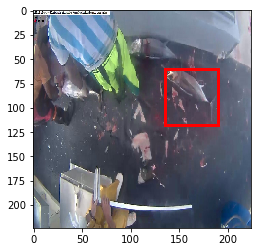

In [171]:
show_bb(0)

### Create & train model

Since we're not allowed (by the kaggle rules) to manually annotate the test set, we'll need to create a model that predicts the locations of the bounding box on each image. To do so, we create a model with multiple outputs: it will predict both the type of fish (the 'class'), and the 4 bounding box coordinates. We prefer this approach to only predicting the bounding box coordinates, since we hope that giving the model more context about what it's looking for will help it with both tasks.

In [174]:
def batch_norm_model_bb(base_model, p):
    
    inputs = Input(shape = base_model.layers[-1].output_shape[1:])
    
    pool_layer = MaxPooling2D()(inputs)
    pool_layer = BatchNormalization()(pool_layer)
        
    flat_layer = Flatten()(pool_layer)
        
    dense_layer_1 = Dropout(p / 4)(flat_layer)
    dense_layer_1 = Dense(512, activation = 'relu')(dense_layer_1)
    dense_layer_2 = BatchNormalization()(dense_layer_1)
    dense_layer_2 = Dropout(p)(dense_layer_2)
    dense_layer_2 = Dense(512, activation = 'relu')(dense_layer_2)
    dense_layer_3 = BatchNormalization()(dense_layer_2)
    dense_layer_3 = Dropout(p / 2)(dense_layer_3)
    
    prediction_bb = Dense(4, name = 'bb')(dense_layer_3)
    prediction_fish = Dense(8, activation = 'softmax', name = 'class')(dense_layer_3)
    
    model = Model(inputs = inputs, outputs = [prediction_bb, prediction_fish])
    
    return model

p = 0.6

Define and compile model

In [179]:
fc_model_bb = batch_norm_model_bb(vgg_conv, p)

fc_model_bb.compile(Adam(lr = 0.001), loss = ['mse','categorical_crossentropy'], metrics = ['accuracy'], loss_weights = [.001, 1.])

And train the model

In [180]:
fc_model_bb.fit(x = conv_feat,
                y = [train_bbox, train_labels],
                batch_size = batch_size,
                epochs = 6,
                validation_data = (conv_valid_feat, [valid_bbox, valid_labels]))

Train on 3281 samples, validate on 496 samples
Epoch 1/6
3281/3281 [==============================] - 5s - loss: 5.5288 - bb_loss: 4440.7432 - class_loss: 1.0881 - bb_acc: 0.3846 - class_acc: 0.6830 - val_loss: 4.4826 - val_bb_loss: 4090.9178 - val_class_loss: 0.3917 - val_bb_acc: 0.4940 - val_class_acc: 0.9032
Epoch 2/6
3281/3281 [==============================] - 3s - loss: 4.1830 - bb_loss: 3861.3110 - class_loss: 0.3217 - bb_acc: 0.4700 - class_acc: 0.9028 - val_loss: 3.4395 - val_bb_loss: 3240.1335 - val_class_loss: 0.1993 - val_bb_acc: 0.5060 - val_class_acc: 0.9577
Epoch 3/6
3281/3281 [==============================] - 3s - loss: 2.9361 - bb_loss: 2759.0266 - class_loss: 0.1770 - bb_acc: 0.5520 - class_acc: 0.9482 - val_loss: 2.2349 - val_bb_loss: 2058.0356 - val_class_loss: 0.1769 - val_bb_acc: 0.5544 - val_class_acc: 0.9556
Epoch 4/6
3281/3281 [==============================] - 3s - loss: 1.7227 - bb_loss: 1594.2802 - class_loss: 0.1284 - bb_acc: 0.6007 - class_acc: 0.9604 - v

Lower the learning rate and train some more.

In [181]:
fc_model_bb.optimizer.lr = 1e-5

fc_model_bb.fit(x = conv_feat,
                y = [train_bbox, train_labels],
                batch_size = batch_size,
                epochs = 10,
                validation_data = (conv_valid_feat, [valid_bbox, valid_labels]))

Train on 3281 samples, validate on 496 samples
Epoch 1/10
3281/3281 [==============================] - 4s - loss: 0.4199 - bb_loss: 362.7165 - class_loss: 0.0572 - bb_acc: 0.6940 - class_acc: 0.9832 - val_loss: 0.4913 - val_bb_loss: 340.7363 - val_class_loss: 0.1506 - val_bb_acc: 0.7339 - val_class_acc: 0.9698
Epoch 2/10
3281/3281 [==============================] - 4s - loss: 0.3566 - bb_loss: 319.3402 - class_loss: 0.0372 - bb_acc: 0.7053 - class_acc: 0.9878 - val_loss: 0.5125 - val_bb_loss: 338.4867 - val_class_loss: 0.1740 - val_bb_acc: 0.6956 - val_class_acc: 0.9718
Epoch 3/10
3281/3281 [==============================] - 3s - loss: 0.3667 - bb_loss: 309.3537 - class_loss: 0.0574 - bb_acc: 0.7037 - class_acc: 0.9799 - val_loss: 0.4828 - val_bb_loss: 308.9791 - val_class_loss: 0.1738 - val_bb_acc: 0.6956 - val_class_acc: 0.9637
Epoch 4/10
3281/3281 [==============================] - 4s - loss: 0.3244 - bb_loss: 285.4017 - class_loss: 0.0390 - bb_acc: 0.6983 - class_acc: 0.9866 - val_

Excitingly, it turned out that the classification model is much improved by giving it this additional task. Let's see how well the bounding box model did by taking a look at its output. First predict the output.

In [184]:
pred = fc_model_bb.predict(conv_valid_feat[0:10])

Define function to plot rectancle

In [187]:
def show_bb_pred(i):
    
    def to_plot(img):
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    
    bb = valid_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plt.imshow(to_plot(valid[i]))
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

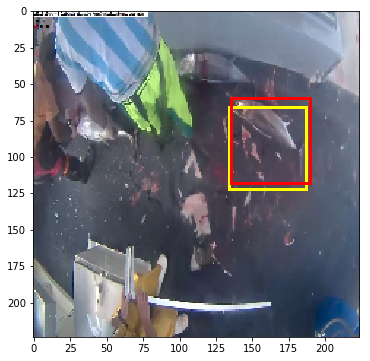

In [188]:
show_bb_pred(0)

And evaluate the model

In [190]:
fc_model_bb.evaluate(conv_valid_feat, [valid_bbox, valid_labels])

480/496 [============================>.] - ETA: 0s

[0.43833116850545328,
 256.71991803569176,
 0.18161123584873312,
 0.72580645161290325,
 0.97177419354838712]

Save weights of the model

In [192]:
fc_model_bb.save_weights(path + 'models/bn_anno.h5')

And load the weights

In [194]:
fc_model_bb.load_weights(path + 'models/bn_anno.h5')

## Larger Images

### Set up data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier (1280x720), without being too big.

In [ ]:
train = get_data(path + 'train', (360, 640))
valid = get_data(path + 'valid', (360, 640))
test_stg1 = get_data(path + 'test', (360, 640))
test_stg2 = get_data(path + 'test_stg2', (360, 640))

The image shows that things are much clearer at this size.

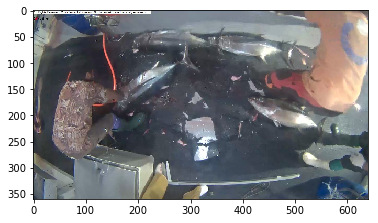

In [395]:
plt.imshow(np.rollaxis(train[0], 0, 1).astype(np.uint8))

Save the features

In [397]:
save_array(path + 'results/train_640.dat', train)
save_array(path + 'results/valid_640.dat', valid)
save_array(path + 'results/test_stg1_640.dat', test_stg1)
save_array(path + 'results/test_stg2_640.dat', test_stg2)

Load the features

In [12]:
train = load_array(path + 'results/train_640.dat')
valid = load_array(path + 'results/valid_640.dat')
test_stg1 = load_array(path + 'results/test_stg1_640.dat')
test_stg2 = load_array(path + 'results/test_stg2_640.dat')

Sizes

In [76]:
train.shape, valid.shape, test_stg1.shape, test_stg2.shape

((3281, 360, 640, 3),
 (496, 360, 640, 3),
 (1000, 360, 640, 3),
 (12153, 360, 640, 3))

We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images, which also means it won't include the fully connected layers (since they don't make sense for non-default sizes). We will also remove the last max pooling layer, since we don't want to throw away information yet.

In [13]:
vgg_640 = Vgg16(size = (360, 640), use_batchnorm = True)

conv_layers, fc_layers = split_at(vgg_640.model, Conv2D)
vgg_conv_640 = Sequential(conv_layers)

# Check size
vgg_conv_640.input_shape, vgg_conv_640.output_shape

((None, 360, 640, 3), (None, 22, 40, 512))

Precompute the features

In [77]:
conv_valid_feat = vgg_conv_640.predict(valid, batch_size = 1, verbose = 1)
conv_train_feat = vgg_conv_640.predict(train, batch_size = 1, verbose = 1)
conv_test_feat_stg1 = vgg_conv_640.predict(test_stg1, batch_size = 1, verbose = 1)
conv_test_feat_stg2 = vgg_conv_640.predict(test_stg2, batch_size = 1, verbose = 1)

12153/12153 [==============================] - 376s   


Inspect shape

In [78]:
conv_valid_feat.shape, conv_train_feat.shape, conv_test_feat_stg1.shape, conv_test_feat_stg2.shape, 

((496, 22, 40, 512),
 (3281, 22, 40, 512),
 (1000, 22, 40, 512),
 (12153, 22, 40, 512))

Save the features 

In [79]:
save_array(path + 'results/conv_valid_640.dat', conv_valid_feat)
save_array(path + 'results/conv_train_640.dat', conv_train_feat)
save_array(path + 'results/conv_test_640_stg1.dat', conv_test_feat_stg1)
save_array(path + 'results/conv_test_640_stg2.dat', conv_test_feat_stg2)

Load the features

In [14]:
conv_valid_feat = load_array(path + 'results/conv_valid_640.dat')
conv_train_feat = load_array(path + 'results/conv_train_640.dat')
conv_test_feat_stg1 = load_array(path + 'results/conv_test_640_stg1.dat')
conv_test_feat_stg2 = load_array(path + 'results/conv_test_640_stg2.dat')

### Fully convolutional net (FCN)

Since we're using a larger input, the output of the final convolutional layer is also larger. So we probably don't want to put a dense layer there - that would be a lot of parameters! Instead, let's use a fully convolutional net (FCN); this also has the benefit that they tend to generalize well, and also seems like a good fit for our problem (since the fish are a small part of the image).

In [328]:
def fully_convolutional_model(base_model, p):
    
    inputs = Input(shape = base_model.layers[-1].output_shape[1:])
    
    norm_layer = BatchNormalization()(inputs)
    
    conv_layer1 = Conv2D(128, kernel_size = (3, 3), activation='relu', padding = 'same')(norm_layer)
    conv_layer1 = BatchNormalization()(conv_layer1)
    conv_layer1 = MaxPooling2D()(conv_layer1)
    
    conv_layer2 = Conv2D(128, kernel_size = (3, 3), activation='relu', padding = 'same')(conv_layer1)
    conv_layer2 = BatchNormalization()(conv_layer2)
    conv_layer2 = MaxPooling2D()(conv_layer2)
    
    conv_layer3 = Conv2D(128, kernel_size = (3, 3), activation='relu', padding = 'same')(conv_layer2)
    conv_layer3 = BatchNormalization()(conv_layer3)
    conv_layer3 = MaxPooling2D((1, 2))(conv_layer3)
    
    conv_layer4 = Conv2D(8, kernel_size = (3, 3), activation='relu', padding = 'same')(conv_layer3)
        
    pool_layer = Dropout(p)(conv_layer4)
    pool_layer = GlobalAveragePooling2D()(pool_layer)
    pool_layer = Activation('softmax')(pool_layer)
    
    model = Model(inputs = inputs, outputs = pool_layer)
    
    return model

p = 0

batch_size = 16

Define and compile model

In [333]:
f_conv_model = fully_convolutional_model(vgg_conv_640, p)

f_conv_model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Inspect model

In [334]:
f_conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 22, 40, 512)       0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 22, 40, 512)       2048      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 22, 40, 128)       589952    
_________________________________________________________________
batch_normalization_30 (Batc (None, 22, 40, 128)       512       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 11, 20, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 20, 128)       147584    
_________________________________________________________________
batch_normalization_31 (Batc (None, 11, 20, 128)       512       
__________

And run training for some batches

In [335]:
f_conv_model.fit(x = conv_train_feat,
                 y = train_labels,
                 batch_size = batch_size,
                 epochs = 6,
                 validation_data = (conv_valid_feat, valid_labels))

Train on 3281 samples, validate on 496 samples
Epoch 1/6
3281/3281 [==============================] - 13s - loss: 0.6961 - acc: 0.7806 - val_loss: 0.5018 - val_acc: 0.8589
Epoch 2/6
3281/3281 [==============================] - 12s - loss: 0.2067 - acc: 0.9418 - val_loss: 0.2509 - val_acc: 0.9234
Epoch 3/6
3281/3281 [==============================] - 11s - loss: 0.0979 - acc: 0.9717 - val_loss: 0.3573 - val_acc: 0.8972
Epoch 4/6
3281/3281 [==============================] - 11s - loss: 0.1061 - acc: 0.9649 - val_loss: 0.1674 - val_acc: 0.9577
Epoch 5/6
3281/3281 [==============================] - 11s - loss: 0.0417 - acc: 0.9890 - val_loss: 0.1387 - val_acc: 0.9617
Epoch 6/6
3281/3281 [==============================] - 11s - loss: 0.0173 - acc: 0.9960 - val_loss: 0.1458 - val_acc: 0.9677


Save the weights

In [291]:
f_conv_model.save_weights(path + 'models/lrg_nmp.h5')

And load the weights

In [292]:
f_conv_model.load_weights(path + 'models/lrg_nmp.h5')

Evaluate the model

In [293]:
f_conv_model.evaluate(conv_valid_feat, valid_labels)

496/496 [==============================] - 1s     


[0.13991075925408833, 0.967741935483871]


Another benefit of this kind of model is that the last convolutional layer has to learn to classify each part of the image (since there's only an average pooling layer after). Let's create a function that grabs the output of this layer (which is the 4th-last layer of our model).

In [294]:
f = f_conv_model.layers
conv_fn = K.function([f[0].input, K.learning_phase()], [f[-4].output])

def get_cm(inp, label):
    conv = conv_fn([inp, 0])[0][0, :, :, label]
    return scipy.misc.imresize(conv, (360, 640), interp = 'nearest')

We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).


In [322]:
inp = np.expand_dims(conv_valid_feat[53], 0)
np.round(f_conv_model.predict(inp)[0], 2)

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

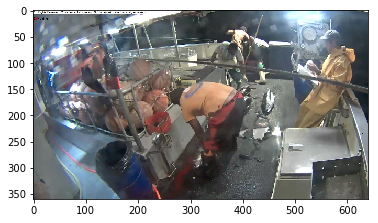

In [321]:
plt.imshow(to_plot(valid[53]))

In [323]:
cm = get_cm(inp, 0)

The heatmap shows that (at very low resolution) the model is finding the fish!

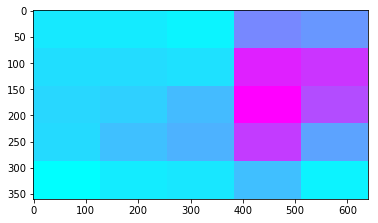

In [324]:
plt.imshow(cm, cmap = "cool")

### All convolutional net heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers, and repeat the previous steps.

In [337]:
def fully_convolutional_model_large(base_model):
    
    inputs = Input(shape = base_model.layers[-1].output_shape[1:])
    
    norm_layer = BatchNormalization()(inputs)
    
    conv_layer1 = Conv2D(128, kernel_size = (3, 3), activation='relu', padding = 'same')(norm_layer)
    conv_layer1 = BatchNormalization()(conv_layer1)
    
    conv_layer2 = Conv2D(128, kernel_size = (3, 3), activation='relu', padding = 'same')(conv_layer1)
    conv_layer2 = BatchNormalization()(conv_layer2)
    
    conv_layer3 = Conv2D(128, kernel_size = (3, 3), activation='relu', padding = 'same')(conv_layer2)
    conv_layer3 = BatchNormalization()(conv_layer3)
    
    conv_layer4 = Conv2D(8, kernel_size = (3, 3), activation='relu', padding = 'same')(conv_layer3)
        
    pool_layer = GlobalAveragePooling2D()(conv_layer4)
    pool_layer = Activation('softmax')(pool_layer)
    
    model = Model(inputs = inputs, outputs = pool_layer)
    
    return model

p = 0

batch_size = 16

Define and compile the model

In [338]:
f_conv_model_large = fully_convolutional_model_large(vgg_conv_640)

f_conv_model_large.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Examine the model

In [339]:
f_conv_model_large.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 22, 40, 512)       0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 22, 40, 512)       2048      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 22, 40, 128)       589952    
_________________________________________________________________
batch_normalization_34 (Batc (None, 22, 40, 128)       512       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 22, 40, 128)       147584    
_________________________________________________________________
batch_normalization_35 (Batc (None, 22, 40, 128)       512       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 22, 40, 128)       147584    
__________

Train the model

In [340]:
f_conv_model_large.fit(x = conv_train_feat,
                       y = train_labels,
                       batch_size = batch_size,
                       epochs = 6,
                       validation_data = (conv_valid_feat, valid_labels))

Train on 3281 samples, validate on 496 samples
Epoch 1/6
3281/3281 [==============================] - 14s - loss: 0.8694 - acc: 0.7123 - val_loss: 0.4409 - val_acc: 0.8609
Epoch 2/6
3281/3281 [==============================] - 12s - loss: 0.3152 - acc: 0.9067 - val_loss: 0.2330 - val_acc: 0.9214
Epoch 3/6
3281/3281 [==============================] - 12s - loss: 0.1537 - acc: 0.9543 - val_loss: 0.2087 - val_acc: 0.9254
Epoch 4/6
3281/3281 [==============================] - 12s - loss: 0.0810 - acc: 0.9759 - val_loss: 0.2805 - val_acc: 0.9153
Epoch 5/6
3281/3281 [==============================] - 12s - loss: 0.0809 - acc: 0.9771 - val_loss: 0.1756 - val_acc: 0.9476
Epoch 6/6
3281/3281 [==============================] - 12s - loss: 0.0376 - acc: 0.9902 - val_loss: 0.1403 - val_acc: 0.9637


We then create the function returning the last convolutional layer.

In [342]:
l_large = f_conv_model_large.layers
conv_fn_large = K.function([l_large[0].input, K.learning_phase()], [l_large[-3].output])

And the function for obtaining the heatmap

In [349]:
def get_cm_large(inp, label):
    conv = conv_fn_large([inp,0])[0][0, :, : , label]
    return scipy.misc.imresize(conv, (360,640))

Get the input again

In [362]:
img_num = 3

inp = np.expand_dims(conv_valid_feat[img_num], 0)
np.round(f_conv_model_large.predict(inp)[0], 2)

array([ 0.94999999,  0.        ,  0.        ,  0.        ,  0.03      ,
        0.        ,  0.        ,  0.02      ], dtype=float32)

And plot the image.

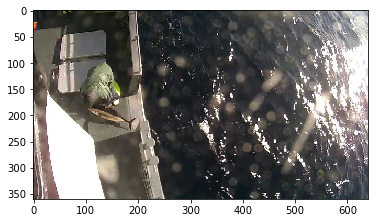

In [363]:
plt.imshow(to_plot(valid[img_num]))

We can then plot the heatmap

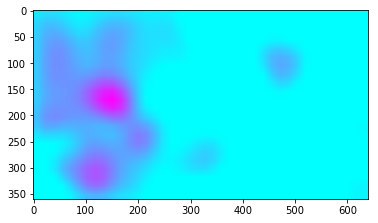

In [364]:
cm = get_cm_large(inp, 0)
plt.imshow(cm, cmap = "cool")

And finally we can layer the images on top of each other.

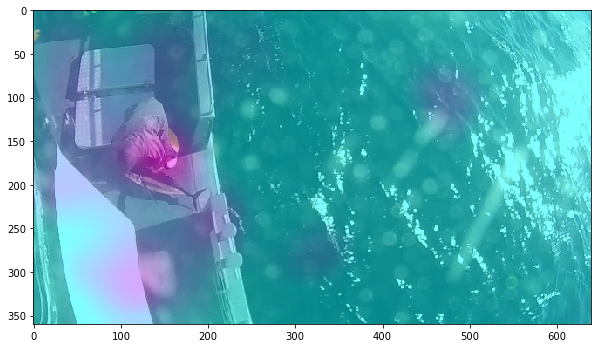

In [366]:
def plot(img):
    plt.imshow(to_plot(img))

plt.figure(figsize = (10, 10))
plot(valid[img_num])
plt.imshow(cm, cmap = "cool", alpha = 0.5)

## Inception mini-net

Here's an example of how to create and use "inception blocks" - as you see, they use multiple different convolution filter sizes and concatenate the results together.

In [80]:
# Convolution block with batchnormalisation
def conv2d_bn(in_layer, filters, kernel_size, strides = (1, 1)):
    
    x = Conv2D(filters, kernel_size = kernel_size, strides = strides,
               activation = 'relu', padding = 'same')(in_layer)
    x = BatchNormalization()(x)
    
    return x

# Define inception block
def incep_block(in_layer):
    
    branch1x1 = conv2d_bn(in_layer, 32, kernel_size = (1, 1), strides = (2, 2))
    branch5x5 = conv2d_bn(in_layer, 24, kernel_size = (1, 1))
    branch5x5 = conv2d_bn(branch5x5, 32, kernel_size = (5, 5), strides = (2, 2))

    branch3x3dbl = conv2d_bn(in_layer, 32, kernel_size = (1, 1))
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, kernel_size = (3, 3))
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, kernel_size = (3, 3), strides = (2, 2))

    branch_pool = AveragePooling2D((3, 3), strides = (2, 2), padding = 'same')(in_layer)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    
    out_layer = concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool])
    
    return out_layer

Define inception net type model

In [81]:
def inception_net(base_model, p = 0.75):
    
    inputs = Input(shape = base_model.layers[-1].output_shape[1:])
    
    x = BatchNormalization()(inputs)
    
    x = incep_block(x)
    x = incep_block(x)
    x = incep_block(x)
    
    x = Dropout(p)(x)
    x = Conv2D(8, kernel_size = (3, 3), padding = 'same')(x)
    x = GlobalAveragePooling2D()(x)
    
    outputs = Activation('softmax')(x)
    
    model = Model(inputs = inputs, outputs = outputs)
    
    return model

Define and compit model

In [82]:
inception_model = inception_net(vgg_conv_640)
inception_model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Finally train the model

In [384]:
inception_model.fit(x = conv_train_feat,
                    y = train_labels,
                    batch_size = batch_size,
                    epochs = 6,
                    validation_data = (conv_valid_feat, valid_labels))

Train on 3281 samples, validate on 496 samples
Epoch 1/6
3281/3281 [==============================] - 27s - loss: 1.0951 - acc: 0.6382 - val_loss: 0.6463 - val_acc: 0.8589
Epoch 2/6
3281/3281 [==============================] - 18s - loss: 0.4328 - acc: 0.8641 - val_loss: 0.2992 - val_acc: 0.9113
Epoch 3/6
3281/3281 [==============================] - 18s - loss: 0.2368 - acc: 0.9293 - val_loss: 0.2669 - val_acc: 0.9194
Epoch 4/6
3281/3281 [==============================] - 18s - loss: 0.1442 - acc: 0.9561 - val_loss: 0.2726 - val_acc: 0.9294
Epoch 5/6
3281/3281 [==============================] - 18s - loss: 0.1276 - acc: 0.9610 - val_loss: 0.2747 - val_acc: 0.9294
Epoch 6/6
3281/3281 [==============================] - 18s - loss: 0.1326 - acc: 0.9570 - val_loss: 0.2181 - val_acc: 0.9335


Lower the learning rate and train some more.

In [385]:
inception_model.optimizer.lr = 1e-5

inception_model.fit(x = conv_train_feat,
                    y = train_labels,
                    batch_size = batch_size,
                    epochs = 6,
                    validation_data = (conv_valid_feat, valid_labels))

Train on 3281 samples, validate on 496 samples
Epoch 1/6
3281/3281 [==============================] - 18s - loss: 0.0927 - acc: 0.9717 - val_loss: 0.2272 - val_acc: 0.9435
Epoch 2/6
3281/3281 [==============================] - 18s - loss: 0.0660 - acc: 0.9793 - val_loss: 0.1848 - val_acc: 0.9476
Epoch 3/6
3281/3281 [==============================] - 18s - loss: 0.0515 - acc: 0.9838 - val_loss: 0.1967 - val_acc: 0.9415
Epoch 4/6
3281/3281 [==============================] - 18s - loss: 0.0991 - acc: 0.9689 - val_loss: 0.1859 - val_acc: 0.9516
Epoch 5/6
3281/3281 [==============================] - 18s - loss: 0.0398 - acc: 0.9884 - val_loss: 0.1487 - val_acc: 0.9657
Epoch 6/6
3281/3281 [==============================] - 18s - loss: 0.0628 - acc: 0.9799 - val_loss: 0.1408 - val_acc: 0.9677


And even more epochs

In [386]:
inception_model.fit(x = conv_train_feat,
                    y = train_labels,
                    batch_size = batch_size,
                    epochs = 10,
                    validation_data = (conv_valid_feat, valid_labels))

Train on 3281 samples, validate on 496 samples
Epoch 1/10
3281/3281 [==============================] - 18s - loss: 0.0302 - acc: 0.9915 - val_loss: 0.1546 - val_acc: 0.9637
Epoch 2/10
3281/3281 [==============================] - 18s - loss: 0.0245 - acc: 0.9942 - val_loss: 0.1682 - val_acc: 0.9617
Epoch 3/10
3281/3281 [==============================] - 18s - loss: 0.0340 - acc: 0.9909 - val_loss: 0.1951 - val_acc: 0.9516
Epoch 4/10
3281/3281 [==============================] - 18s - loss: 0.0927 - acc: 0.9671 - val_loss: 0.1961 - val_acc: 0.9415
Epoch 5/10
3281/3281 [==============================] - 18s - loss: 0.0788 - acc: 0.9735 - val_loss: 0.1857 - val_acc: 0.9577
Epoch 6/10
3281/3281 [==============================] - 18s - loss: 0.0250 - acc: 0.9927 - val_loss: 0.1718 - val_acc: 0.9617
Epoch 7/10
3281/3281 [==============================] - 18s - loss: 0.0418 - acc: 0.9866 - val_loss: 0.2282 - val_acc: 0.9556
Epoch 8/10
3281/3281 [==============================] - 18s - loss: 0.0

Descent result for a single model. Save the weights.

Save the weights

In [388]:
inception_model.save_weights(path + 'models/inception_net.h5')

Load the weights

In [83]:
inception_model.load_weights(path + 'models/inception_net.h5')

## Pseudolabeling

Finally we try and improve the results using pseudo labelling. We use the MixIterator class to mix, validation, training and test images in appropriate shares. First concatenate the test data sets.

In [84]:
# Join test features
conv_test_feat = np.concatenate((conv_test_feat_stg1, conv_test_feat_stg2), axis = 0)

# Print shapes
print(conv_test_feat.shape, conv_test_feat_stg1.shape, conv_test_feat_stg2.shape)

(13153, 22, 40, 512) (1000, 22, 40, 512) (12153, 22, 40, 512)


Then predict the labels.

In [85]:
preds_test = inception_model.predict(conv_test_feat,
                                     batch_size = 7,
                                     verbose = 1)

13153/13153 [==============================] - 50s    


Create batches

In [86]:
gen = image.ImageDataGenerator()

test_batches = gen.flow(conv_test_feat, preds_test, batch_size = 16)
valid_batches = gen.flow(conv_valid_feat, valid_labels, batch_size = 4)
train_batches = gen.flow(conv_train_feat, train_labels, batch_size = 44)

C:\Users\anlaursen\AppData\Loca\Anaconda3\envs\py3\lib\site-packages\keras\preprocessing\image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (13153, 22, 40, 512) (512 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')
C:\Users\anlaursen\AppData\Loca\Anaconda3\envs\py3\lib\site-packages\keras\preprocessing\image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (496, 22, 40, 512) (512 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')
C:\Users\anlaursen\AppData\Loca\Anaconda3\envs\py3\lib\site-packages\keras\preprocessing\image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (c

Create the Mixed iterator

In [88]:
mix_batches = MixIterator([train_batches, test_batches, valid_batches])

Train the model with the pseudo labels

In [89]:
inception_model.fit_generator(mix_batches,
                              steps_per_epoch = mix_batches.steps_per_epoch,
                              epochs = 12,
                              validation_data = valid_batches,
                              validation_steps = valid_batches.n / valid_batches.batch_size)

Epoch 1/12
264/264 [==============================] - 74s - loss: 0.1989 - acc: 0.9436 - val_loss: 0.0092 - val_acc: 0.9980
Epoch 2/12
264/264 [==============================] - 69s - loss: 0.1750 - acc: 0.9486 - val_loss: 0.0090 - val_acc: 1.0000
Epoch 3/12
264/264 [==============================] - 70s - loss: 0.1617 - acc: 0.9503 - val_loss: 0.0068 - val_acc: 1.0000
Epoch 4/12
264/264 [==============================] - 70s - loss: 0.1461 - acc: 0.9605 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 5/12
264/264 [==============================] - 70s - loss: 0.1404 - acc: 0.9612 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 6/12
264/264 [==============================] - 70s - loss: 0.1446 - acc: 0.9601 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 7/12
264/264 [==============================] - 69s - loss: 0.1353 - acc: 0.9656 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 8/12
264/264 [==============================] - 70s - loss: 0.1345 - acc: 0.9659 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 9/

Run some more epochs, as we saw a general trend of improvement.

In [90]:
inception_model.fit_generator(mix_batches,
                              steps_per_epoch = mix_batches.steps_per_epoch,
                              epochs = 12,
                              validation_data = valid_batches,
                              validation_steps = valid_batches.n / valid_batches.batch_size)

Epoch 1/12
264/264 [==============================] - 73s - loss: 0.1247 - acc: 0.9714 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 2/12
264/264 [==============================] - 70s - loss: 0.1222 - acc: 0.9725 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3/12
264/264 [==============================] - 70s - loss: 0.1238 - acc: 0.9712 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 4/12
264/264 [==============================] - 70s - loss: 0.1213 - acc: 0.9729 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 5/12
264/264 [==============================] - 70s - loss: 0.1206 - acc: 0.9721 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 6/12
264/264 [==============================] - 70s - loss: 0.1222 - acc: 0.9717 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 7/12
264/264 [==============================] - 70s - loss: 0.1195 - acc: 0.9738 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 8/12
264/264 [==============================] - 70s - loss: 0.1158 - acc: 0.9758 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 9/

## Submit results

Submit the final results to Kaggle. Evaluate first.

In [91]:
inception_model.evaluate(conv_valid_feat, valid_labels, batch_size * 2)

496/496 [==============================] - 6s     


[0.0018180653963598512, 1.0]

Predict labels for test set.

In [121]:
preds = inception_model.predict(conv_test_feat, batch_size = 7, verbose = 1)

13153/13153 [==============================] - 213s   


In [122]:
def do_clip(arr, mx): return np.clip(arr, (1 - mx) / 7, mx)

subm = do_clip(preds, 0.82)

Create submission names.

In [123]:
subm_name = path + 'results/subm_inception.gz'

Define classes in right order

In [124]:
# classes = sorted(batches.class_indices, key=batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

Create submission dataframe in pandas.

In [136]:
stg2_names = ['test_stg2/' + x for x in raw_test_stg2_filenames]

submission = pd.DataFrame(subm, columns = classes)
submission.insert(0, 'image', raw_test_filenames + stg2_names)
print(submission.head())

           image       ALB       BET       DOL       LAG       NoF     OTHER  \
0  img_00005.jpg  0.025714  0.025714  0.025714  0.025714  0.820000  0.025714   
1  img_00007.jpg  0.050167  0.025714  0.133671  0.276820  0.025714  0.509845   
2  img_00009.jpg  0.820000  0.025714  0.025714  0.025714  0.025714  0.025714   
3  img_00018.jpg  0.820000  0.025714  0.025714  0.025714  0.025714  0.025714   
4  img_00027.jpg  0.820000  0.025714  0.025714  0.025714  0.026513  0.025714   

      SHARK       YFT  
0  0.025714  0.025714  
1  0.025714  0.025714  
2  0.025714  0.025714  
3  0.025714  0.025714  
4  0.025714  0.059120  


Finally save submissions

In [137]:
submission.to_csv(subm_name, index = False, compression = 'gzip')

In [138]:
stg2_names[0:10]

['test_stg2/image_00001.jpg',
 'test_stg2/image_00002.jpg',
 'test_stg2/image_00003.jpg',
 'test_stg2/image_00004.jpg',
 'test_stg2/image_00005.jpg',
 'test_stg2/image_00006.jpg',
 'test_stg2/image_00007.jpg',
 'test_stg2/image_00008.jpg',
 'test_stg2/image_00009.jpg',
 'test_stg2/image_00010.jpg']